In [1]:
# Importujeme si opět knihovny jako minule
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

from keras import layers
# %matplotlib ipympl

TensorFlow version: 2.16.2
Keras version: 3.5.0


In [2]:
# Naivní One-hot encoding
sentences = ['The cat sat on the mat', 'The dog ate my homework']
words = []
for s in sentences:
    words.extend(s.lower().split())

tokens = list(set(words))
tokens.insert(0, "") # Pro nulový vektor :)
print(tokens, "\n")

for w in "my dog ate cat".split():
    i = tokens.index(w)
    print(f"{w} {[int(i == y) for y in range(len(tokens))]}")

['', 'homework', 'mat', 'on', 'sat', 'ate', 'dog', 'my', 'the', 'cat'] 

my [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
dog [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
ate [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
cat [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [3]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#sequences_to_matrix
from tensorflow.keras.preprocessing.text import Tokenizer

# Argumentem num_words lze nastavit aby Tokenizer bral v potaz pouze num_words nejčetnějších slov
tokenizer = Tokenizer()

tokenizer.fit_on_texts(sentences)
print(tokenizer.word_index)

# Alternativně lze věta popsat pouze indexy tokenů
tokenizer.texts_to_sequences(sentences)

{'the': 1, 'cat': 2, 'sat': 3, 'on': 4, 'mat': 5, 'dog': 6, 'ate': 7, 'my': 8, 'homework': 9}


[[1, 2, 3, 4, 1, 5], [1, 6, 7, 8, 9]]

In [4]:
# nebo tím jaké slova obsahuje.
tokenizer.texts_to_matrix(sentences)

array([[0., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1., 1., 1.]])

In [5]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000
maxlen = 500
batch_size = 32

(train_data, train_target), (test_data, test_target) = imdb.load_data(num_words=max_features)
print(len(train_data), 'train sequences')
print(len(test_data), 'test sequences')

25000 train sequences
25000 test sequences


In [6]:
# Co však naše data obsahují?

# Jak vypadá část první recenze?
print(train_data[0][:20])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]


In [7]:
word_index = imdb.get_word_index()
reversed_word_index = {v: k for k, v in word_index.items()}

In [8]:
# Jak vypadá první recenze?
first_review = train_data[0]
first_20 = first_review[:20]

words = []
for i in first_20:
    words.append(reversed_word_index[i])

print(first_20)

# A teď se slovy:
",".join(words)

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25]


'the,as,you,with,out,themselves,powerful,lets,loves,their,becomes,reaching,had,journalist,of,lot,from,anyone,to,have'

In [9]:
# Potřebujeme aby vtupní sekvence byly pevné délky
# takže sekvence doplníme o prázdné slova "" – nulové vektory reprezentované tokenem 0
input_train = sequence.pad_sequences(train_data, maxlen=maxlen)
input_test = sequence.pad_sequences(test_data, maxlen=maxlen)

input_train.shape

(25000, 500)

In [48]:
# Naivně
model = keras.models.Sequential([
    layers.Embedding(max_features, 32),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

trained = model.fit(
    input_train, train_target,
    epochs=10, 
    batch_size=256,
    validation_split=0.2,
    verbose=False
)

acc         0.943400
loss        0.193673
val_acc     0.779600
val_loss    0.621566
Name: 9, dtype: float64

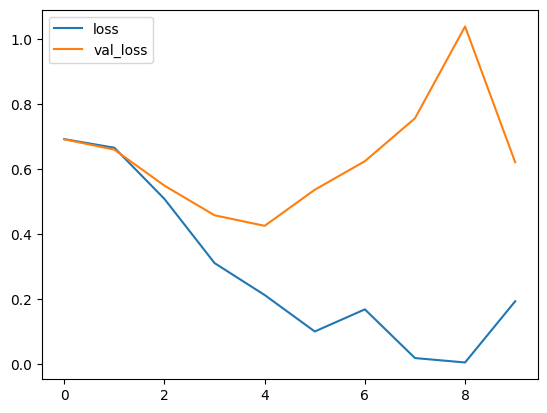

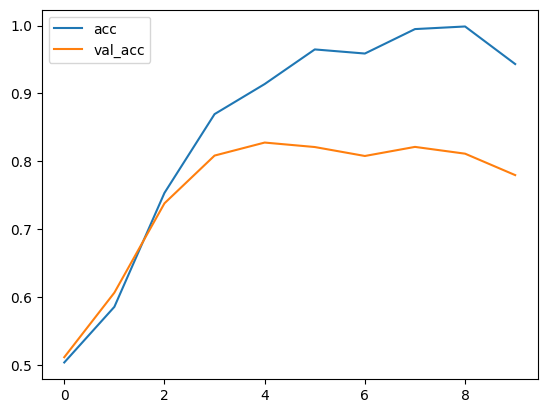

In [52]:
history = pd.DataFrame(trained.history)

history.loc[:, ['loss', 'val_loss']].plot()
history.loc[:, ['acc', 'val_acc']].plot()

# V poslední epoše.
history.iloc[-1]

In [53]:
# To není tak špatné :)
results = model.evaluate(input_test, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - acc: 0.7727 - loss: 0.5917


In [14]:
model = keras.models.Sequential([
    layers.Embedding(max_features, 16),
    layers.SimpleRNN(16),
    # Vyzkoušejte si i pokročilejší architektury:
    # layers.LSTM(16),
    # layers.GRU(16),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

trained = model.fit(
    input_train,
    train_target,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    verbose=False
)

#### Výstupy Dense vrstev
- v případě klasických **Dense(units)** vrstev je při učení vtupem N-D tensor (batch_size, ..., input_features) – většinou 2-D (batch_size, input_features)
- výstupem je pak N-D tensor (batch_size, ..., units) – ve 2-D (batch_size, units)

#### Výstupy RNN vrstev
- rekurentní sítě přijímají (babatch_sizetch, timesteps, input_features)
- rekurentní sítě mohou vracet jeden ze dvou typů výstupů:
    - běžně vrátí poslední výstup pro každou vstupní sekvenci: (batch_size, output_features)
    - sekvenci po sobě jdoucích výstupů pro každý časový krok (a to v případě parametru **return_sequences=True**): (batch_size, timesteps, output_features) 

acc         0.961300
loss        0.117731
val_acc     0.846400
val_loss    0.402579
Name: 9, dtype: float64

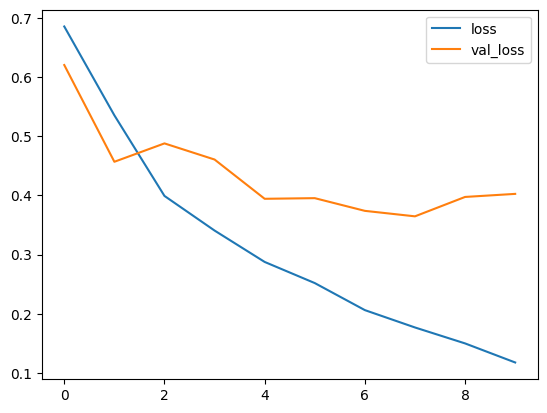

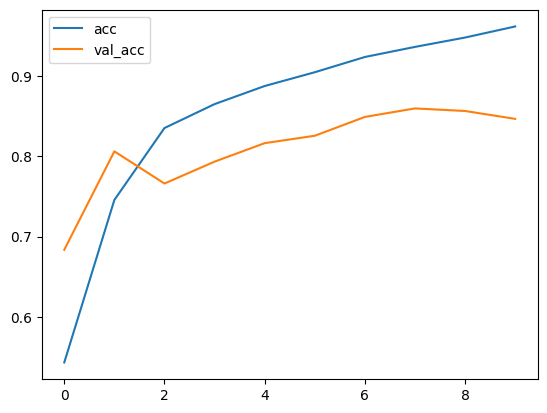

In [15]:
history = pd.DataFrame(trained.history)

history.loc[:, ['loss', 'val_loss']].plot()
history.loc[:, ['acc', 'val_acc']].plot()

# V poslední epoše.
history.iloc[-1]

In [16]:
results = model.evaluate(input_test, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - acc: 0.8381 - loss: 0.4193


In [73]:
# Jak zvládat přeučení ?
model = keras.models.Sequential([
    layers.Embedding(max_features, 16),
    layers.LSTM(16,
                # Podíl jednotek, které mají být vynulovány na vstupu
                # dropout=0.1,
                # Podíl jednotek, které mají být vynulovány jako výstupy v čase
                # recurrent_dropout= 0.1,
                return_sequences=True),
    layers.Dropout(0.2),
    layers.LSTM(16),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['acc']
)

trained = model.fit(
    input_train,
    train_target,
    epochs=15,
    batch_size=128,
    validation_split=0.2,
    verbose=False
)

acc         0.957400
loss        0.122255
val_acc     0.881800
val_loss    0.388914
Name: 14, dtype: float64

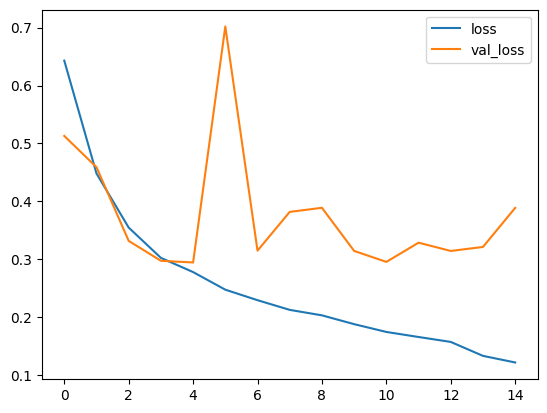

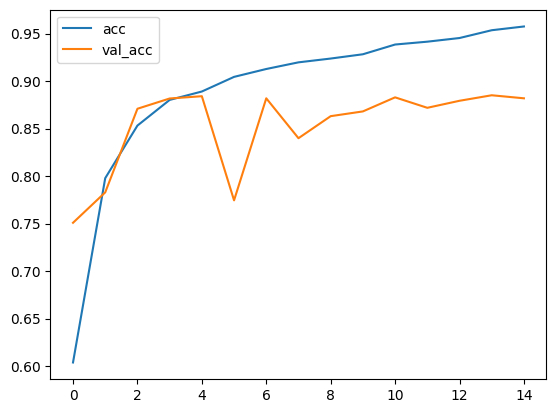

In [74]:
history = pd.DataFrame(trained.history)

history.loc[:, ['loss', 'val_loss']].plot()
history.loc[:, ['acc', 'val_acc']].plot()

# V poslední epoše.
history.iloc[-1]

In [75]:
# Oproti nainvnímu modelu jsme se zlepšily zhruba o 10%
results = model.evaluate(input_test, test_target)

782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - acc: 0.8674 - loss: 0.4333


In [66]:
# Pointa je v tom, že máme data o rencenzích, kde velkou roli hrají četnosti a samotný výskyt slov. Recenze obsahující slova "bad", "horrible", atd. budou mít negativní význam, zatímco recenze se slovy "good", "great", ... budou mít význam opačný.
# U datasetů, kde pořadí hraje větší roli by byl výsledek znatelnější :)